# Stackplot notebook - V3 - LRA - geojson

### List of wetland edits

push to github every time you change one of these!!!!

- wofs bit flags - include low angle wofs -pushed
- ditch no data values -pushed
- text wrapping -pushed
- escape additional apostrophes -pushed
- wofs bit flags - include sea wofs - pushed

- check 12 missing shapes
- geojson parsing
- check for 90% coverage of shape, not just load
- check for overlaps
- if no data, redo load with no 90% thing, then monthly aggregate before checking for coverage
-  tighten graph and increase text size

- wofs - plot to see what the actual values are in between 
- wofs - fill gaps with ndwi
- wofs - plot against surface reflectance

- use bens awesome stats code to gap fill?

- rolling average for inference?
        

## this will require you to pip install --user geojson

### import modules


In [69]:
import datacube
import datetime
import fiona
import geojson
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from textwrap import wrap

from datacube.storage import masking
from datacube.utils import geometry
from digitalearthau.utils import wofs_fuser

sys.path.append('/g/data/r78/rjd547/jupyter_notebooks/dea-notebooks/10_Scripts')
import DEADataHandling, DEAPlotting, TasseledCapTools

dc = datacube.Datacube(app='tci and wofs')

global Output_dir
Output_dir = '/g/data/r78/rjd547/LRA/LRA_Outputs_v1/'

### Get polygon from geojson

In [70]:
poly_path = '/g/data/r78/rjd547/shapefiles/LGA_AOI_Rural_Properties_extract_20190322.geojson'

In [ ]:
# with open(poly_path)as f:
#     data = geojson.load(f)   

In [71]:
# def get_LRA_polyName(geojson):
#     ''' function designed specifically for the LRA australia geojson. Takes the shapefile and extracts
#     the ramsar name, wetland name and objectID from the ESRI shapefile format and turns it into a useful string for our output.
#     :Inputs: shapefile with RAMSAR_NAM, WETLAND_NA, and OBJECTID as properties. 
#     Author: Bex Dunn Last Edited: March 2019'''
#     #get the polyname from the shapes 
    


#     for feature in data['features']:
#         print (feature['properties']['NAME'])
#     RAMSAR_NAME = '_'.join(shapefile['properties']['RAMSAR_NAM'].split(' '))
#     WETLAND_NAME = '_'.join(shapefile['properties']['WETLAND_NA'].split(' '))
#     STATE = '_'.join(shapefile['properties']['STATE'].split(' ')) 
#     ID = shapefile['id']
#     polyName = f'{RAMSAR_NAME}-{WETLAND_NAME}-{STATE}-{ID}'
#     print(f'processing polygon {polyName}')
#     return(polyName)

In [72]:
LRA_table = gpd.read_file(poly_path)
LRA_table.head()

,OBJECTID,FEATURETYPE,NAME,FEATURERELIABILITY,FEATURESOURCE,ATTRIBUTERELIABILITY,ATTRIBUTESOURCE,PLANIMETRICACCURACY,LOCALGOVERNMENT,COMMENT_,PROPERTYAREA,SHAPE_Length,SHAPE_Area,geometry
0,1,Rural Property,Table Mount,2016-01-15T00:00:00,Qld_Digital Cadastral Database,2016-06-01T00:00:00,Qld_Digital Cadastral Database,10,Cloncurry Shire,None,42508180.0,0.243380,0.003684,(POLYGON ((140.7941745180001 -20.5832264579999...
1,2,Rural Property,Burslem,2016-01-15T00:00:00,Qld_Digital Cadastral Database,2006-06-01T00:00:00,Qld_Dept Agriculture Fisheries and Forestry,10,Flinders Shire,None,16167200.0,0.171211,0.001402,(POLYGON ((144.2676145180001 -22.0195641579999...
2,3,Rural Property,Burslem,2016-01-15T00:00:00,Qld_Digital Cadastral Database,2006-06-01T00:00:00,Qld_Dept Agriculture Fisheries and Forestry,10,Flinders Shire,None,0.0,0.141900,0.001237,"(POLYGON ((144.447062595 -22.06445131699996, 1..."
3,4,Rural Property,Charteris,2016-01-15T00:00:00,Qld_Digital Cadastral Database,2016-06-01T00:00:00,Qld_Digital Cadastral Database,10,Cloncurry Shire,None,7270000.0,0.111684,0.000453,"(POLYGON ((140.528134804 -20.78897223999996, 1..."
4,5,Rural Property,Charteris,2016-01-15T00:00:00,Qld_Digital Cadastral Database,2016-06-01T00:00:00,Qld_Digital Cadastral Database,10,Cloncurry Shire,None,7270000.0,0.048253,0.000138,"(POLYGON ((140.505578224 -20.77879649199997, 1..."


In [3]:
# def get_LRA_polyName(geojson):
#     ''' function designed specifically for the LRA australia geojson. Takes the geojson file  and extracts
#     the polygon name and objectID andturns it into a useful string for our output.
#     :Inputs: geojson with OBJECTID and NAME as properties. 
#     Author: Bex Dunn Last Edited: May 2019'''
#     # get name shapes 
#     NAME = '_'.join(geojson['properties']['NAME'].split(' '))
#     OBJECTID = shapefile['id']
#     polyName = f'{RAMSAR_NAME}-{WETLAND_NAME}-{STATE}-{ID}'
#     print(f'processing polygon {polyName}')
#     return(polyName)

### change the path here if you want a different polygon

In [76]:
#open the polygon and manually select your favourite polygon the lazy way
with fiona.open(poly_path) as geojsonfeatures:
        crs = geometry.CRS(geojsonfeatures.crs_wkt)
        first_geometry = next(iter(geojsonfeatures))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)
        for feature in geojsonfeatures:
            #
            print (feature['properties']['OBJECTID'])
            
#             #print(feature['properties']['WETLAND_NA'])
             #if feature['properties']['NAME']=='Table Mount':
#                 feature_OI =feature
#                 feature_OI_geometry = feature_OI['geometry']
#                 geom = geometry.Geometry(feature_OI_geometry, crs=crs)
#                 print(feature_OI)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [25]:
def get_masked_ls578_data(query, geom):
    '''create a function that takes in the masked proportion, query and geometry and returns the fully masked surface reflectance data'''
    ## Set up datasets
    #set cloudmasking threshold and load landsat nbart data
    landsat_masked_prop = 0.90
    ls578_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart',
            masked_prop=landsat_masked_prop)

    ### mask the data with our original polygon to remove extra data 

    data = ls578_ds
    mask = rasterio.features.geometry_mask([geom.to_crs(data.geobox.crs)for geoms in [geom]],
                                               out_shape=data.geobox.shape,
                                               transform=data.geobox.affine,
                                               all_touched=False,
                                               invert=False)

    #for some reason xarray is not playing nicely with our old masking function
    mask_xr = xr.DataArray(mask, dims = ('y','x'))
    ls578_ds = data.where(mask_xr==False)
    return ls578_ds, mask_xr

In [26]:
def get_masked_tcw(sr_data, mask, threshold=-350):
    '''uses TasseledCapTools and an input threshold (defaults to -350) to create masked over-threshold tasseled cap '''

    #transform the nbart into tci
    tci = TasseledCapTools.thresholded_tasseled_cap(ls578_ds,wetness_threshold=-350, drop=True , drop_tc_bands=True)

    #select only finite values (over threshold values)
    tcw = xr.ufuncs.isfinite(tci.wetness_thresholded)

    # #reapply the polygon mask
    tcw = tcw.where(mask_xr==False)

    return tcw

### Set up query

In [27]:
query = {'geopolygon': geom,
         #'time': ('1993-01-01', '1994-01-01')
         }

### Load data sets, where 90% of data is unmasked

#### Landsat data

In [28]:
#load and mask data. selecting data with more than 90% clear for the geobox around the polygon... #FIXME
ls578_ds, mask_xr= get_masked_ls578_data(query,geom)

Loading ls5
    Loading 302 filtered ls5 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Loading 60 filtered ls7 timesteps
Loading ls8
    Loading 112 filtered ls8 timesteps
Combining and sorting ls5, ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [29]:
#calculate tasselled cap wetness within masked AOI
tcw = get_masked_tcw(ls578_ds, mask_xr, threshold=-350)

In [30]:

#wofls = dc.load(product = 'wofs_albers', like=ls578_ds, fuse_func=wofs_fuser)
wofls = dc.load(product = 'wofs_albers',fuse_func=wofs_fuser, **query)

#first, match tcw and wofs

In [31]:
wofls = wofls.where(wofls.time==tcw.time)

In [32]:
# #reapply the polygon mask
wofls = wofls.where(mask_xr==False)

In [33]:
wet_wofs = wofls.where(wofls.water==128)

In [34]:
shadow_wofs = wofls.where(wofls.water== 136) #use bit values for wet (128) and terrain/low-angle (8)

In [35]:
sea_wofs = wofls.where(wofls.water==132) #bit values for wet (128) and sea (4)
sea_shadow_wofs = wofls.where(wofls.water==140)# bit values for wet (128) and sea (4) and terrain/low-angle (8)

(124, 150)

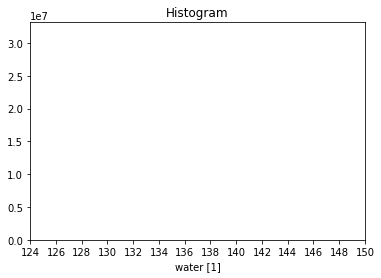

In [36]:
wofls.water.plot.hist(bins=list(range(0,234,2)))
plt.xlim(124,150)
plt.xticks(ticks=list(range(0,234,2)))
plt.xlim(124,150)

## load in fractional cover data

In [37]:
#load the data according to our query
#choose a mask proportion to look for a clear timestep
fc_ds = DEADataHandling.load_clearlandsat(dc, query,product='fc',masked_prop=0.90)

Loading ls5
    Loading 302 filtered ls5 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Loading 60 filtered ls7 timesteps
Loading ls8
    Loading 111 filtered ls8 timesteps
Combining and sorting ls5, ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


### mask FC with polygon

In [38]:
fc_ds = fc_ds.where(mask_xr==False)

### mask FC with wetness

In [39]:
fc_ds_noTCW=fc_ds.where(tcw==False)
#match timesteps
fc_ds_noTCW= fc_ds_noTCW.where(fc_ds_noTCW.time==tcw.time)

### Calculate the dominant fraction for each pixel in Fractional Cover

In [40]:
#drop data percentage and Unmixing Error
fc_tester = fc_ds_noTCW.drop(['data_perc','UE'])

#following robbi's advice, cast the dataset to a dataarray
maxFC = fc_tester.to_array(dim='variable', name='maxFC')

#turn FC array into integer only as nanargmax doesn't seem to handle floats the way we want it to
FC_int = maxFC.astype('int8')

#use numpy.nanargmax to get the index of the maximum value along the variable dimension
#BSPVNPV=np.nanargmax(FC_int, axis=0)
BSPVNPV=FC_int.argmax(dim='variable')

FC_mask=xr.ufuncs.isfinite(maxFC).all(dim='variable')

# #re-mask with nans to remove no-data
BSPVNPV=BSPVNPV.where(FC_mask)

### Calculate number of pixels in area of interest

In [41]:
#number of pixels in area of interest
pixels = (mask_xr==0).sum(dim=['x','y'])

In [42]:
#count number of tcw pixels
tcw_pixel_count = tcw.sum(dim=['x','y'])

In [43]:
FC_dominant = xr.Dataset({
    'BS': (BSPVNPV==0).where(FC_mask),
    'PV': (BSPVNPV==1).where(FC_mask),
    'NPV': (BSPVNPV==2).where(FC_mask),
})

In [44]:
#number of pixels in area of interest
pixels = (mask_xr==0).sum(dim=['x','y'])

In [45]:
#count number of wofs pixels
wofs_pixels = (wet_wofs.water.count(dim=['x','y'])+shadow_wofs.water.count(dim=['x','y']) +
sea_wofs.water.count(dim=['x','y'])+sea_shadow_wofs.water.count(dim=['x','y']))
wofs_pixels

<xarray.DataArray 'water' (time: 473)>
array([0, 0, 0, ..., 5, 3, 5])
Coordinates:
  * time     (time) datetime64[ns] 1986-08-22T23:57:06 ... 2019-04-12T00:35:13.500000

In [46]:
# #count number of wofs pixels
# wofs_pixels = wet_wofs.water.sum(dim=['x','y'])/128

In [47]:
#count percentage of area of wofs
wofs_area_percent = (wofs_pixels/pixels)*100
#wofs_area_percent

In [48]:
#count number of tcw pixels
tcw_pixel_count = tcw.sum(dim=['x','y'])

In [49]:
#calculate percentage area wet
tcw_area_percent = (tcw_pixel_count/pixels)*100

In [50]:
#calculate wet not wofs
tcw_less_wofs = tcw_area_percent-wofs_area_percent

In [51]:
#drop data percentage and Unmixing Error
fc_tester = fc_ds_noTCW.drop(['data_perc','UE'])

In [52]:
#following robbi's advice, cast the dataset to a dataarray
maxFC = fc_tester.to_array(dim='variable', name='maxFC')

In [53]:
#turn FC array into integer only as nanargmax doesn't seem to handle floats the way we want it to
FC_int = maxFC.astype('int8')

In [54]:
#use numpy.nanargmax to get the index of the maximum value along the variable dimension
#BSPVNPV=np.nanargmax(FC_int, axis=0)
BSPVNPV=FC_int.argmax(dim='variable')

In [55]:
#work out where we have actual values!
FC_mask=xr.ufuncs.isfinite(maxFC).all(dim='variable')

# #re-mask with nans to remove no-data
BSPVNPV=BSPVNPV.where(FC_mask)

In [56]:
#restack the Fractional cover dataset all together
FC_dominant = xr.Dataset({
    'BS': (BSPVNPV==0).where(FC_mask),
    'PV': (BSPVNPV==1).where(FC_mask),
    'NPV': (BSPVNPV==2).where(FC_mask),
})

In [57]:
FC_count = FC_dominant.sum(dim=['x','y'])

In [58]:
#Fractional cover pixel count method
#Get number of FC pixels, divide by total number of pixels per polygon
#Work out the number of nodata pixels in the data, so that we can graph the variables by number of observed pixels.

Bare_soil_percent=(FC_count.BS/pixels)*100

Photosynthetic_veg_percent=(FC_count.PV/pixels)*100

NonPhotosynthetic_veg_percent=(FC_count.NPV/pixels)*100

NoData = 100 - wofs_area_percent- tcw_less_wofs - Photosynthetic_veg_percent - NonPhotosynthetic_veg_percent - Bare_soil_percent

In [59]:
NoDataPixels = (NoData/100) * pixels 

In [60]:
#Fractional cover pixel count method
#Get number of FC pixels, divide by total number of pixels per polygon

Bare_soil_percent2=(FC_count.BS/(pixels - NoDataPixels))*100

Photosynthetic_veg_percent2=(FC_count.PV/(pixels- NoDataPixels))*100

NonPhotosynthetic_veg_percent2=(FC_count.NPV/(pixels- NoDataPixels))*100

In [61]:
#count percentage of area of wofs
wofs_area_percent2 = (wofs_pixels/(pixels - NoDataPixels))*100
#wofs_area_percent

In [62]:
#count number of tcw pixels
tcw_pixel_count2 = tcw.sum(dim=['x','y'])

In [63]:
#calculate percentage area wet
tcw_area_percent2 = (tcw_pixel_count2/(pixels - NoDataPixels))*100

In [64]:
#calculate wet not wofs
tcw_less_wofs2 = tcw_area_percent2-wofs_area_percent2

In [65]:
#last check for timestep matching before we plot
wofs_area_percent2=wofs_area_percent2.where(wofs_area_percent2.time==Bare_soil_percent2.time)
Bare_soil_percent2=Bare_soil_percent2.where(Bare_soil_percent2.time==wofs_area_percent2.time)
Photosynthetic_veg_percent2=Photosynthetic_veg_percent2.where(Photosynthetic_veg_percent2.time==wofs_area_percent2.time)
NonPhotosynthetic_veg_percent2=NonPhotosynthetic_veg_percent2.where(NonPhotosynthetic_veg_percent2.time==wofs_area_percent2.time)

NameError: name 'polyName' is not defined

<Figure size 432x288 with 0 Axes>

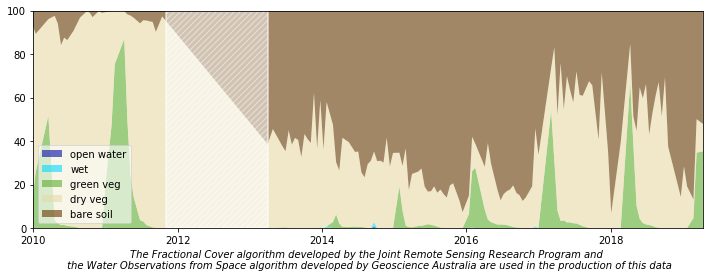

In [68]:

#set up color palette
pal = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"],
       sns.xkcd_rgb["brown"]]       

#make a stacked area plot
plt.clf()
fig= plt.figure(figsize = (12,4))
plt.stackplot(wofs_area_percent.time.values, 
              wofs_area_percent2, 
              tcw_less_wofs2, 
              Photosynthetic_veg_percent2, 
              NonPhotosynthetic_veg_percent2,
              Bare_soil_percent2,
              labels=['open water',
                      'wet',
                      'green veg',
                      'dry veg',
                      'bare soil',
                     ], colors=pal, alpha = 0.6)



#set axis limits to the min and max
#plt.axis(xmin = wofs_area_percent2.time[0].data, xmax = wofs_area_percent2.time[-1].data, ymin = 0, ymax = 100)
plt.axis(xmin = datetime(2010,1,1), xmax = wofs_area_percent2.time[-1].data, ymin = 0, ymax = 100)
#add a legend and a tight plot box
plt.legend(loc='lower left', framealpha=0.6)
#plt.tight_layout()

#create rectangle borders for no-data times (SLC-off only)
LS5_8_gap_start = datetime(2011,11,1)
LS5_8_gap_end = datetime(2013,4,1)

# convert to matplotlib date representation
gap_start = mdates.date2num(LS5_8_gap_start)
gap_end = mdates.date2num(LS5_8_gap_end)
gap = gap_end - gap_start


#set date ticks every year
years = mdates.YearLocator(2)
yearsFmt = mdates.DateFormatter('%Y')
ax = plt.gca()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
#ax.yaxis.set_ticks(np.arange(0,110,10))
ax.set_xlabel(f'The Fractional Cover algorithm developed by the Joint Remote'
f' Sensing Research Program and \n the Water Observations from Space algorithm '
f'developed by Geoscience Australia are used in the production of this data',style='italic')


#set up rectangle
slc_rectangle= Rectangle((gap_start,0), gap, 100,alpha = 0.5, facecolor=sns.xkcd_rgb['white'],
             edgecolor=sns.xkcd_rgb['white'], hatch="////",linewidth=2)
ax.add_patch(slc_rectangle)
#fig.autofmt_xdate()


#polyName='test a really really really stupidly extremely long name that is far too long and I can\'t even what the blah blah blah blah blah '

polyName=polyName.replace("'","\\'")
title=ax.set_title("\n".join(wrap(f'Percentage of area WOfS, Wetness, Fractional Cover for {polyName}')))
fig.tight_layout()
title.set_y(1.05)

#save the figure
plt.savefig(f'{Output_dir}{polyName}.png')#, transparent=True)
plt.show()
print(f'plot created for {polyName}')


## test area plot

In [ ]:
import matplotlib as mpl
#set up color palette for just the fractional cover
fc_colors = [sns.xkcd_rgb["brown"], #0
       sns.xkcd_rgb["grass"], #1
       sns.xkcd_rgb["beige"]] #2
fc_norm=mpl.colors.BoundaryNorm([0,1,2,3],3)

In [ ]:
#thresholded TCW is boolean type, so need a two-step color map with transparent and a color
tcw_colors = ('#00000000',sns.xkcd_rgb["neon blue"]) #neon blue to transparent
#we use "NoNorm" because our data should only come in 0 and 1s
tcw_norm = mpl.colors.NoNorm(0,1)

In [ ]:
#thresholded wofs is boolean type, so need a two-step color map with transparent and a color
wofs_colors = ('#00000000',sns.xkcd_rgb["cobalt blue"]) #cobalt blue to transparent
#use the same Norm as tcw
wofs_norm = tcw_norm

In [ ]:
import datetime
scene=0
scene_day= np.datetime_as_string(tcw.isel(time=scene).time.values, unit='D')

In [ ]:
#plot the results to check they look roughly like what we are expecting
plt.clf()
plt.imshow(BSPVNPV[scene],cmap=mpl.colors.ListedColormap(colors=fc_colors), norm=fc_norm, alpha =0.7)

###us numpy to turn data into a float so the colormap doesn't break
plt.imshow(tcw.isel(time=scene).astype(np.float32), cmap=mpl.colors.ListedColormap(colors=tcw_colors), norm=tcw_norm, alpha =0.6)
plt.imshow(wet_wofs.water.isel(time=scene),cmap=mpl.colors.ListedColormap(colors =wofs_colors), norm = wofs_norm, alpha =0.5 )
#note shadow wofs not plotted here!!!!!!! #FIXME
plt.tick_params(
    axis= 'both', #both x and y
    which = 'both', # both major and minor ticks
    bottom = False, #turn off ticks on bottom
    left = False, # turn off ticks on left
    labelbottom = False, #turn off ticklabels on the bottom
    labelleft = False        #turn of ticklabels on the left
    )
plt.title(f'WOfS, Wetness, Fractional Cover for {scene_day}')
plt.tight_layout()
#plt.savefig(f'/g/data/r78/rjd547/Macquarie_Marsh/Mac_FC_{scene_day}.png')